# Quanvolutional Neural Networks

In this task we implement a Quanvolutional Neural Network as first introduced in Ref[1]. 

### Convolutional Neural Networks

A CNN is a special Deep Learning algorithm that is particularly suitable for tasks such as image classification, detection, and segmentation.

The input images are typically W $\times$ H $\times$ 3 arrays, where W is the image's width and H its height. so if we were to flatten this array and use it as a typical input layer of a neural network, the resulting model would be very computationally inefficient.
<div style="text-align:center">
    <img src="img/CNN.webp" alt="Alt Text" style="width:800px;"/>
    <p>A typical Convolutional Neural Netwok <a href="https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53">(source)</a>.</p>
</div>

Convolutional Neural Networks, among other things, help solve this problem. Here is how a CNN model works:

1. The input image (in this case, a 28 $\times$ 28 grayscale image of a digit) is passed through several convolutional filters (kernels). Each filter is typically a small matrix, such as a 5 $\times$ 5 matrix, which slides over the input image, computing the dot product between the filter and sections of the input image. The resulting values are stored in a series of feature maps, one map per kernel. Each filter can be optimized to detect a certain feature of the the input image, the resulting feature maps (matrices that represent the presence of specific features detected by that filter at different locations in the image) thus encode those features.

2. After the convolution, an activation function (typically ReLU) is applied to introduce non-linearity. This helps the network learn more complex patterns.

3. Following the convolution and activation, a max-pooling operation is applied to reduce the spatial dimensions of the feature maps, making the network more computationally efficient and providing a form of translation invariance.

4. Steps 1-3 can be repeated again multiple times, depending on the inputs' complexities, before the last group of channels is flattened and  fed into a regular Network for classification purposes. 

The figure above summarizes these steps.

### Quantum Convolution

We will implement here a model that is very simmilar to the one presented in Ref.[1]. In stead of a matrix filter, a quantum circuit is going to do the convulotion by:

1. encoding a small region of the input image (2 $\times$ 2 square) into the quantum state of 4-qubit register.
2. evolving the system with a Unitary $U$, whose action could be random and static or optimizable (we will implement the staic case for brevity.)
3. measuring the system and storing each outcome into a different feature map.
4. iterating this procedure over all 2 $\times$ 2 squares, so the full imput image is scanned. There sulting feature maps of the input image can be structured as a multi-channel image.

The below figure summarizes this procedure. The main advantge of having a quantum circuit do the convolution is that it could implement very complex kernels better than the classical filter method.

<div style="text-align:center">
    <img src="img/QNN.png" alt="Alt Text" style="width:800px; height:500px;"/>
    <p>A typical Convolutional Neural Netwok <a href="https://pennylane.ai/qml/demos/tutorial_quanvolution/">(source)</a>.</p>
</div>


We begin by importing PennyLane with the TensorFlow interface as well as keras to get the MNIST dataset.

In [37]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

Next we specify the model's hyper parameters. the unitary $U$ will composed of a single evolution layer to speed up computation time. 

In [38]:
n_epochs = 30   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 50    # Size of the train dataset
n_test = 30     # Size of the test dataset

SAVE_PATH = "pre-processed_imgs/"  # Data saving folder
PREPROCESS = False           # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator

Next we load the MNIST dataset and divide it into a training set and an evaluation set, normalize the pixel values, and pad the `train_images` and `test_images` arrays with an extra dimension in anticipation for the 4 convolution channels.

In [39]:
mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

# Reduce dataset size
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

# Add extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

Now we implement the Quanvolutional circuit. We will incode classical pixel values via RY rotations with angles $\in [0, \pi]$. The Unitary $U$ is a single layer of random rotations and random entangling gates on the 4 qubits. 

The circuit's 4 outputs (which encode the convolution result for each of the 4 feature maps) are the expectation values of the `PauliZ` operator in each the 4 single-qubit states.

In [40]:
dev = qml.device("default.qubit", wires=4)
# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev)
def circuit(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

We define a function `quanv` that takes a single image and returns the 4 feature maps.

In [41]:
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with out quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

Since, in our implementation, the quantum circuit is not optimizable (that is, the unitary $U$'s action isn't going to be optimized for better feature detection for example,) we can just run `quanv` on each of the `n_train + n_test` images and save each's feature maps locally for later feeding into the classical Neural Network.

In [42]:
np.shape(train_images)

(50, 28, 28, 1)

In [43]:
# If feature maps haven't been generated:
if PREPROCESS == True:
    
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)


# Load pre-processed images
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

Let's visualize the 4 feature maps of 4 samples from `q_train_images`

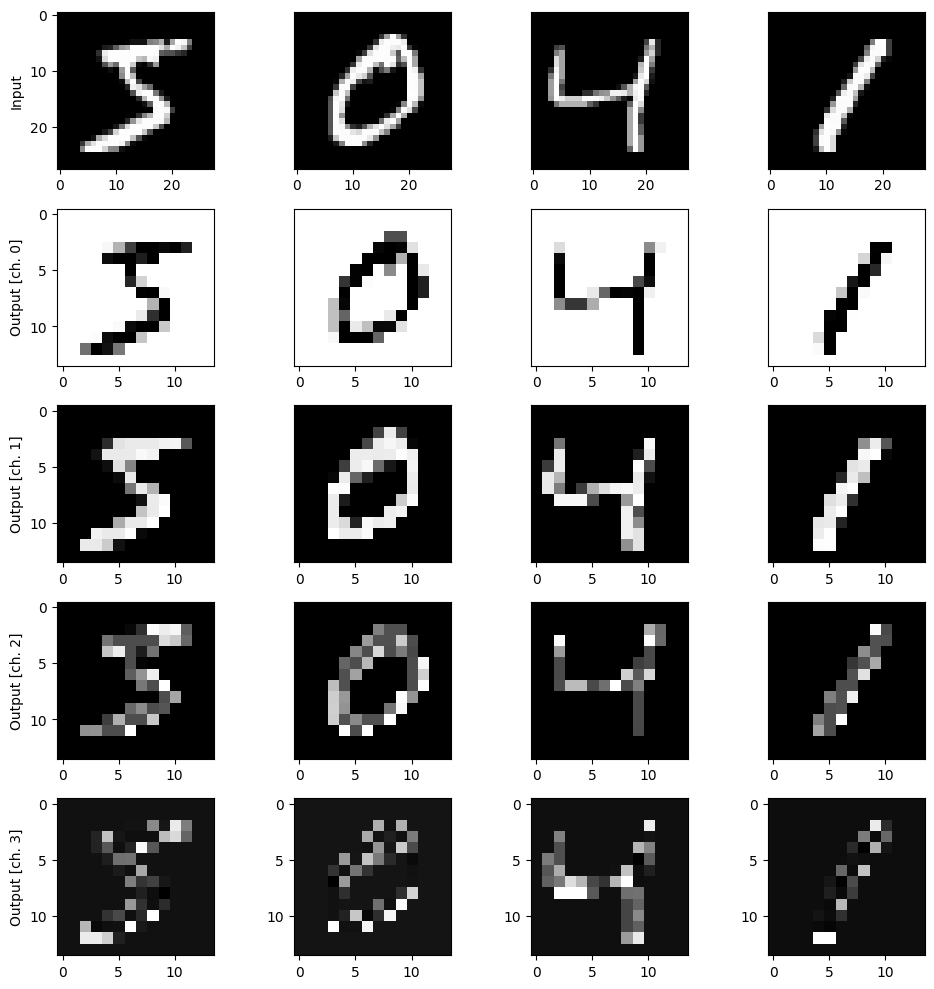

In [44]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

We notice that the (random!) quantum kernel lowered the image's resolution and blurred the its shape while still maintaining some global features (eg, outlines.)

Now that our feature maps are generated, we feed them to a classical Neural Network to to be classifed into the 10 different digits of the MNIST dataset. 

The Neural Netwok consists of a Fletten Layer, which converts the multi-dimensional feature maps into input vectors for the NN, and a `Dense` (Fully Connected) Layer with 10 neurons for the output vector and a final *softmax* activation function.

Below we define the NN model and compile it with a stochastic-gradient-descent optimizer and a cross-entropy loss function.

In [45]:
def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(), # Flatten Layer
        keras.layers.Dense(10, activation="softmax") # Fully connected layer
    ])

    model.compile(
        optimizer='adam', # Adaptive Moment Estimation algorithm
        loss="sparse_categorical_crossentropy", # Loss function
        metrics=["accuracy"], # Measures the fraction of correctly predicted instances
    )
    return model

We now begin the training of the model. We input the pre-processed dataset (the feature maps) `q_train_images` along with their labels `train_labels` for training, and the corresponding datasets for evaluation.

In [46]:
q_model = MyModel()

q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 1s - 39ms/step - accuracy: 0.2800 - loss: 2.4707 - val_accuracy: 0.2000 - val_loss: 2.2602
Epoch 2/30
13/13 - 0s - 4ms/step - accuracy: 0.4600 - loss: 1.8316 - val_accuracy: 0.2333 - val_loss: 2.0827
Epoch 3/30
13/13 - 0s - 4ms/step - accuracy: 0.5800 - loss: 1.5443 - val_accuracy: 0.3000 - val_loss: 1.9268
Epoch 4/30
13/13 - 0s - 3ms/step - accuracy: 0.6800 - loss: 1.2611 - val_accuracy: 0.3667 - val_loss: 1.7706
Epoch 5/30
13/13 - 0s - 4ms/step - accuracy: 0.8000 - loss: 1.0507 - val_accuracy: 0.5000 - val_loss: 1.6591
Epoch 6/30
13/13 - 0s - 4ms/step - accuracy: 0.8600 - loss: 0.8816 - val_accuracy: 0.5333 - val_loss: 1.5706
Epoch 7/30
13/13 - 0s - 4ms/step - accuracy: 0.9600 - loss: 0.7466 - val_accuracy: 0.5667 - val_loss: 1.4958
Epoch 8/30
13/13 - 0s - 4ms/step - accuracy: 0.9600 - loss: 0.6373 - val_accuracy: 0.5667 - val_loss: 1.4326
Epoch 9/30
13/13 - 0s - 4ms/step - accuracy: 0.9600 - loss: 0.5477 - val_accuracy: 0.6000 - val_loss: 1.3799
Epoch 10/30
13/13 

We next instantiate a fully classical Neural network from `MyModel` that takes in the input data straight from the MNIST dataset without the quantum pre-proccessing, and compare the two models.

In [47]:
c_model = MyModel()

c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 0s - 37ms/step - accuracy: 0.1800 - loss: 2.2339 - val_accuracy: 0.3333 - val_loss: 2.1170
Epoch 2/30
13/13 - 0s - 4ms/step - accuracy: 0.4800 - loss: 1.8585 - val_accuracy: 0.4333 - val_loss: 1.9572
Epoch 3/30
13/13 - 0s - 4ms/step - accuracy: 0.6800 - loss: 1.5879 - val_accuracy: 0.5333 - val_loss: 1.8176
Epoch 4/30
13/13 - 0s - 4ms/step - accuracy: 0.8400 - loss: 1.3623 - val_accuracy: 0.5333 - val_loss: 1.7002
Epoch 5/30
13/13 - 0s - 4ms/step - accuracy: 0.8800 - loss: 1.1742 - val_accuracy: 0.5667 - val_loss: 1.6038
Epoch 6/30
13/13 - 0s - 3ms/step - accuracy: 0.9000 - loss: 1.0181 - val_accuracy: 0.6000 - val_loss: 1.5250
Epoch 7/30
13/13 - 0s - 4ms/step - accuracy: 0.9400 - loss: 0.8885 - val_accuracy: 0.6333 - val_loss: 1.4601
Epoch 8/30
13/13 - 0s - 4ms/step - accuracy: 0.9400 - loss: 0.7806 - val_accuracy: 0.6667 - val_loss: 1.4060
Epoch 9/30
13/13 - 0s - 4ms/step - accuracy: 0.9400 - loss: 0.6902 - val_accuracy: 0.6667 - val_loss: 1.3604
Epoch 10/30
13/13 

### Results

We plot below the valuatoin accuracy and loss of both models vs training epoch

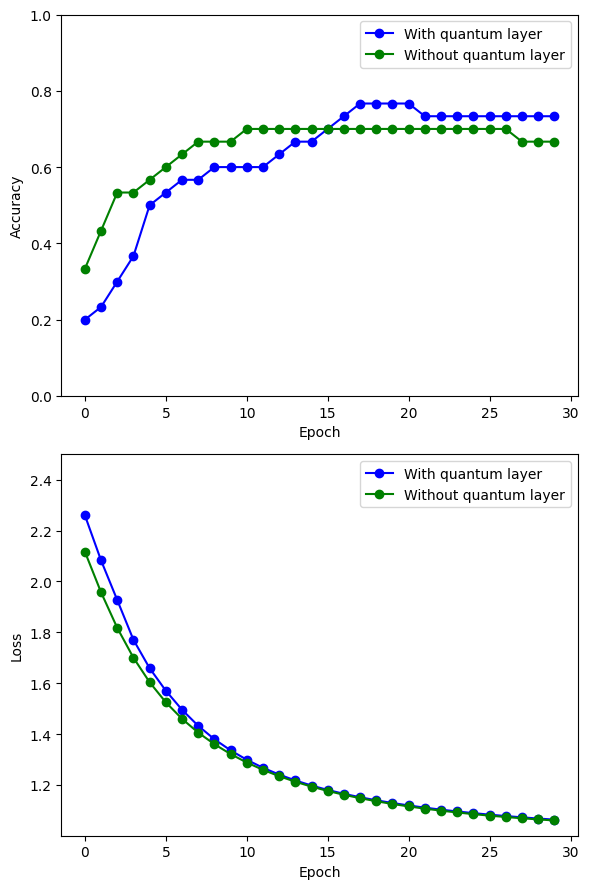

In [48]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()

Despite our very simple Quanvolutional Layer, the NN associalted assicociated with the quatum pre-proccessing still perforemes well in comparison to a fully classical NN. 

### References

[1] Maxwell Henderson, Samriddhi Shakya, Shashindra Pradhan, Tristan Cook. “Quanvolutional Neural Networks: Powering Image Recognition with Quantum Circuits.” arXiv:1904.04767, 2019.

[2] Medium: [A Comprehensive Guide to Convolutional Neural Networks](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53) by Sumit Saha